# EpiInfer-CONTACT: Complete Corrected Implementation (Algorithms 1–5)

In [1]:
import numpy as np
import pandas as pd
import math
import random
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

## Complete implementation of EpiInfer-CONTACT from the research paper:
| # | Name | Purpose |
|--:|------|----------|
| 1 | `CONTACTINFER-CORE` | One-day infection inference loop using contact tracing |
| 2 | `predict_exposures` | Predicts who becomes newly exposed given contacts |
| 3 | `find_prob_exposure` | Computes exposure probability per susceptible |
| 4 | `simulate_epiinfer_core` | Aggregate meeting-distribution version (uses mean contacts) |
| 5 | `continuous_calibrate` | Searches (p₁, p₂) to minimize RMSE on training data |

## UTILITY FUNCTIONS

In [2]:
def adjacency_from_pairs(contacts_per_day, population):
    """Convert contact pairs into adjacency dictionary for each day."""
    adj = {}
    for d, pairs in contacts_per_day.items():
        dayadj = {p: set() for p in population}
        for a, b in pairs:
            dayadj[a].add(b)
            dayadj[b].add(a)
        adj[d] = dayadj
    return adj

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return math.sqrt(mean_squared_error(y_true, y_pred))

# ========== ALGORITHM 3: FINDPROB ==========

def find_prob_exposure(adj_per_day, exposed_set, person, p1, day):
    """
    Algorithm 3 from paper: Calculate probability that susceptible person
    becomes exposed on given day based on contacts with exposed individuals.

    Returns: 1 - (1 - p1)^countEncounters
    """
    if day not in adj_per_day:
        return 0.0

    # Count encounters with exposed individuals
    encounters = len(adj_per_day[day].get(person, set()) & exposed_set)

    # Probability of NOT getting infected from all encounters
    return 1 - (1 - p1)**encounters if encounters > 0 else 0.0

# ========== ALGORITHM 2: PREDICT ==========

def predict_exposures(adj_per_day, BelExp_d, BelSusc_d, p1, day):
    """
    Algorithm 2 from paper: Predict who becomes newly exposed given contacts.

    Strategy:
    1. Calculate exposure probability for each susceptible
    2. Compute expected number N of new exposures
    3. Select top N individuals with highest exposure probability

    Returns: (set of newly exposed, dict of raw probabilities)
    """
    # Calculate exposure probability for each susceptible
    raw_probs = {s: find_prob_exposure(adj_per_day, BelExp_d, s, p1, day)
                 for s in BelSusc_d}

    # Expected number of newly exposed
    N = int(round(sum(raw_probs.values())))

    if N <= 0:
        return set(), raw_probs

    # Select top N individuals by probability
    sorted_susc = sorted(raw_probs.items(), key=lambda kv: -kv[1])
    chosen = {pid for pid, _ in sorted_susc[:N]}

    return chosen, raw_probs


## MAIN CLASS

In [3]:
class EpiInferCore:
    """
    Main class implementing all EpiInfer-CONTACT algorithms.
    Supports both contact-tracing and meeting-distribution approaches.
    """

    def __init__(self, population, contacts_per_day=None):
        """
        Initialize with population and optional contact tracing data.

        Parameters:
        - population: list of individual IDs
        - contacts_per_day: dict {day: [(person_a, person_b), ...]}
        """
        self.population = list(population)
        self.pop_set = set(population)
        self.contacts_adj = adjacency_from_pairs(contacts_per_day, population) if contacts_per_day else {}

    # ========== ALGORITHM 1: CONTACTINFER-CORE (CORRECTED) ==========

    def contactinfer_run(self, p1, p2, inc, initial_exposed, initial_infected,
                         max_day=20, duration_infected=7, stochastic=True):
        """
        Algorithm 1 from paper: Main contact-tracing inference loop.

        CORRECTION: Line 8 of Algorithm 1 states "choose each member of
        BelievedNewExposed(d+1-inc) with probability p2"

        This implementation now correctly uses probabilistic sampling.

        Parameters:
        - p1: probability of exposure per contact with exposed person
        - p2: probability exposed person becomes infected
        - inc: incubation period (days)
        - initial_exposed: set of initially exposed individuals
        - initial_infected: set of initially infected individuals
        - max_day: number of days to simulate
        - duration_infected: how long someone stays infected
        - stochastic: if True, use probabilistic sampling; if False, use expected values

        Returns: DataFrame with daily statistics
        """
        # Initialize tracking dictionaries
        self.BelNewExp = defaultdict(set)
        self.BelNewInf = defaultdict(set)
        self.BelExp = defaultdict(set)
        self.BelInf = defaultdict(set)

        # Day 1 initialization
        self.BelNewExp[1] = set(initial_exposed)
        self.BelNewInf[1] = set(initial_infected)
        self.BelExp[1] = set(initial_exposed)
        self.BelInf[1] = set(initial_infected)

        records = []

        for d in range(1, max_day + 1):
            # Current state
            exp_d = self.BelExp[d]
            inf_d = self.BelInf[d]

            # Susceptible = Everyone - (Exposed ∪ Infected)
            susc_d = self.pop_set - (exp_d | inf_d)

            # Algorithm 2: Predict new exposures
            new_exp, raw_probs = predict_exposures(self.contacts_adj, exp_d, susc_d, p1, d)
            self.BelNewExp[d + 1] = new_exp
            self.BelExp[d + 1] = exp_d | new_exp

            # Algorithm 1 Line 8: Infections from exposures inc days ago (CORRECTED)
            src_day = d + 1 - inc
            new_inf = set()

            if src_day >= 1:
                old_exp = self.BelNewExp[src_day]

                if stochastic:
                    # CORRECT: Each individual becomes infected with probability p2
                    new_inf = {e for e in old_exp if random.random() < p2}
                else:
                    # Deterministic approximation using expected value
                    k = int(round(p2 * len(old_exp)))
                    # Random sample to avoid bias from ordering
                    if k > 0 and len(old_exp) > 0:
                        new_inf = set(random.sample(list(old_exp), min(k, len(old_exp))))

            self.BelNewInf[d + 1] = new_inf

            # Active infections = all infections within duration window
            window = range(max(1, d + 1 - duration_infected + 1), d + 2)
            active_inf = set().union(*[self.BelNewInf[t] for t in window])
            self.BelInf[d + 1] = active_inf

            records.append({
                "day": d,
                "new_exposed": len(new_exp),
                "new_infected": len(new_inf),
                "total_exposed": len(self.BelExp[d + 1]),
                "total_infected": len(self.BelInf[d + 1]),
                "expected_new_exposed": int(round(sum(raw_probs.values())))
            })

        return pd.DataFrame(records)

    # ========== ALGORITHM 4: EPIINFER-CORE (CORRECTED) ==========

    def simulate_epiinfer_core(self, p1, p2, inc, NewInf_hist, asymp_hist,
                              recovered_hist, mean_meetings, max_day):
        """
        Algorithm 4 from paper: Meeting-distribution based inference.

        CORRECTION: Now properly implements Equation 3 (asymptomaticNotEx)
        which subtracts already-exposed and recovered individuals.

        Uses Equations 1-5 from the paper:
        1. palreadyexp: probability someone is already exposed
        2. pnewexposed: probability susceptible becomes exposed
        3. asymptomaticNotEx: population that could be newly exposed
        4. NewExposed: expected number of newly exposed
        5. NewInf: predicted new infections

        Parameters:
        - p1: exposure probability per contact
        - p2: probability exposed becomes infected
        - inc: incubation period
        - NewInf_hist: dict {day: count} of initial infections
        - asymp_hist: dict {day: count} of asymptomatic population
        - recovered_hist: dict {day: count} of recovered population
        - mean_meetings: dict {day: average_contacts}
        - max_day: number of days to predict

        Returns: dict {day: predicted_new_infections}
        """
        NewInf = defaultdict(int, NewInf_hist)
        asymp = defaultdict(int, asymp_hist)
        recovered = defaultdict(int, recovered_hist)
        preds = {}

        for d in range(1, max_day + 1):
            t = d - inc

            # Before incubation period ends, use known values
            if t < 1:
                preds[d] = NewInf.get(d, 0)
                continue

            # === Equation (1): Probability already exposed at time t ===
            numerator = sum([NewInf.get(d - i, 0) for i in range(1, inc + 1)])
            denominator = p2 * max(1, asymp[t])
            palreadyexp = min(numerator / denominator, 1.0) if denominator > 0 else 0

            # === Equation (2): Probability of new exposure ===
            # For individual meeting n_y people: 1 - (1-p1)^(n_y * palreadyexp)
            mean_contacts = mean_meetings.get(t, 0)
            p_newexposed = 1 - (1 - p1) ** (mean_contacts * palreadyexp)

            # === Equation (3): asymptomaticNotEx (CORRECTED) ===
            # Subtract those already exposed and recovered
            already_exposed_count = numerator / p2 if p2 > 0 else 0
            asymptomaticNotEx = (asymp[t]
                                - already_exposed_count
                                - recovered.get(t, 0))
            asymptomaticNotEx = max(0, asymptomaticNotEx)  # Ensure non-negative

            # === Equation (4): Expected newly exposed ===
            NewExposed = asymptomaticNotEx * p_newexposed

            # === Equation (5): Predicted new infections ===
            preds[d] = int(round(p2 * NewExposed))
            NewInf[d] = preds[d]

        return preds

    # ========== ALGORITHM 5: CONTINUOUSCALIBRATE ==========

    def continuous_calibrate(self, observed_newinf, inc, mean_meetings,
                           asymp_hist=None, recovered_hist=None,
                           p2_values=None, training_window=5, verbose=False):
        """
        Algorithm 5 from paper: Find optimal p1 and p2 parameters.

        Strategy:
        - Grid search over p2 values (0.1 to 1.0)
        - Binary search for best p1 for each p2
        - Minimize RMSE on training window

        Parameters:
        - observed_newinf: dict {day: count} of observed infections
        - inc: incubation period
        - mean_meetings: dict {day: average_contacts}
        - asymp_hist: dict {day: count} of asymptomatic population
        - recovered_hist: dict {day: count} of recovered population
        - p2_values: list of p2 values to test (default: 0.1 to 1.0)
        - training_window: number of recent days to use for RMSE
        - verbose: print progress

        Returns: dict with keys 'p1', 'p2', 'rmse'
        """
        if p2_values is None:
            p2_values = [round(x, 2) for x in np.arange(0.1, 1.01, 0.1)]

        # Setup default histories if not provided
        days = sorted(observed_newinf.keys())
        if asymp_hist is None:
            asymp_hist = {d: len(self.population) for d in days}
        if recovered_hist is None:
            recovered_hist = {d: 0 for d in days}

        # Training window
        end_day = max(days)
        start_day = max(1, end_day - training_window + 1)
        obs = [observed_newinf.get(d, 0) for d in range(start_day, end_day + 1)]

        best = {"p1": None, "p2": None, "rmse": float("inf")}

        # Grid search over p2
        for p2 in p2_values:
            lo, hi = 0.0, 1.0

            # Binary search for p1 (up to 15 iterations)
            for iteration in range(15):
                mid = (lo + hi) / 2.0

                # Run simulation with current parameters
                preds = self.simulate_epiinfer_core(
                    mid, p2, inc,
                    {1: observed_newinf.get(1, 0)},
                    asymp_hist,
                    recovered_hist,
                    mean_meetings,
                    end_day
                )

                # Calculate RMSE on training window
                pred = [preds.get(d, 0) for d in range(start_day, end_day + 1)]
                error = rmse(obs, pred)

                # Update best parameters
                if error < best["rmse"]:
                    best.update({"p1": mid, "p2": p2, "rmse": error})

                # Binary search update
                if np.mean(pred) > np.mean(obs):
                    hi = mid  # Predictions too high, reduce p1
                else:
                    lo = mid  # Predictions too low, increase p1

            if verbose:
                print(f"p2={p2:.1f} → best_p1≈{best['p1']:.3f}, RMSE={best['rmse']:.3f}")

        return best


## MONTE CARLO STOCHASTIC SIMULATION

In [4]:
def stochastic_contactinfer(core, p1, p2, inc, initial_exposed, initial_infected,
                            max_day=20, duration_infected=7, n_runs=100):
    """
    Monte Carlo version of EpiInfer-CONTACT.
    Runs multiple stochastic realizations and returns mean ± std trajectories.

    Parameters:
    - core: EpiInferCore instance
    - n_runs: number of Monte Carlo runs
    - other parameters: same as contactinfer_run

    Returns: DataFrame with mean and std for each metric
    """
    all_runs = []

    for run in range(n_runs):
        df = core.contactinfer_run(
            p1, p2, inc, initial_exposed, initial_infected,
            max_day, duration_infected, stochastic=True
        )
        all_runs.append(df)

    # Aggregate statistics across runs
    df_combined = pd.concat(all_runs)
    df_stats = df_combined.groupby("day").agg(["mean", "std"]).reset_index()
    df_stats.columns = ['_'.join(col).strip('_') for col in df_stats.columns.values]

    return df_stats

## EXAMPLE 1: CONTACT-TRACING SIMULATION

EXAMPLE 1: Contact-Tracing Simulation (Algorithms 1-3)

Contact-Tracing Results:
   day  new_exposed  new_infected  total_exposed  total_infected  \
0    1            0             0              2               1   
1    2            1             2              3               3   
2    3            1             0              4               2   
3    4            1             1              5               3   
4    5            0             1              5               2   
5    6            0             1              5               3   
6    7            0             0              5               2   
7    8            0             0              5               1   

   expected_new_exposed  
0                     0  
1                     1  
2                     1  
3                     1  
4                     0  
5                     0  
6                     0  
7                     0  


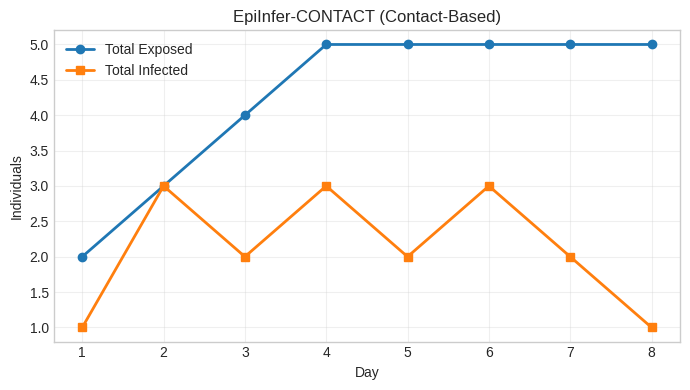

In [5]:
print("="*60)
print("EXAMPLE 1: Contact-Tracing Simulation (Algorithms 1-3)")
print("="*60)

population = list(range(10))
contacts = {
    1: [(0,1),(1,2),(2,3),(3,4)],
    2: [(0,2),(1,3),(2,4),(5,6)],
    3: [(1,4),(2,5),(3,6),(7,8)],
    4: [(0,3),(2,6),(4,7),(8,9)]
}

core = EpiInferCore(population, contacts)
df_contact = core.contactinfer_run(
    p1=0.3, p2=0.5, inc=2,
    initial_exposed={0,1},
    initial_infected={9},
    max_day=8,
    duration_infected=3,
    stochastic=True
)
print("\nContact-Tracing Results:")
print(df_contact)

# Visualization
plt.figure(figsize=(7,4))
plt.plot(df_contact["day"], df_contact["total_exposed"], 'o-', label="Total Exposed", lw=2)
plt.plot(df_contact["day"], df_contact["total_infected"], 's-', label="Total Infected", lw=2)
plt.xlabel("Day")
plt.ylabel("Individuals")
plt.title("EpiInfer-CONTACT (Contact-Based)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# EXAMPLE 2: MEETING-DISTRIBUTION SIMULATION

In [6]:
print("\n" + "="*60)
print("EXAMPLE 2: Meeting-Distribution Simulation (Algorithm 4)")
print("="*60)

mean_meetings = {d: np.random.uniform(1, 3) for d in range(1, 10)}
observed = {1:1, 2:2, 3:3, 4:4, 5:3, 6:2, 7:2, 8:1}
asymp_hist = {d: 50 for d in range(1, 10)}
recovered_hist = {d: 0 for d in range(1, 10)}

preds = core.simulate_epiinfer_core(
    p1=0.25, p2=0.5, inc=2,
    NewInf_hist=observed,
    asymp_hist=asymp_hist,
    recovered_hist=recovered_hist,
    mean_meetings=mean_meetings,
    max_day=8
)

df_preds = pd.DataFrame({
    "day": list(preds.keys()),
    "predicted_NewInf": list(preds.values())
})
print("\nMeeting-Distribution Predictions:")
print(df_preds)


EXAMPLE 2: Meeting-Distribution Simulation (Algorithm 4)

Meeting-Distribution Predictions:
   day  predicted_NewInf
0    1                 1
1    2                 2
2    3                 2
3    4                 2
4    5                 1
5    6                 2
6    7                 2
7    8                 2


# EXAMPLE 3: PARAMETER CALIBRATION


EXAMPLE 3: Parameter Calibration (Algorithm 5)
p2=0.1 → best_p1≈0.750, RMSE=1.265
p2=0.2 → best_p1≈0.750, RMSE=1.183
p2=0.3 → best_p1≈0.750, RMSE=1.183
p2=0.4 → best_p1≈0.750, RMSE=1.183
p2=0.5 → best_p1≈0.750, RMSE=1.183
p2=0.6 → best_p1≈0.750, RMSE=1.183
p2=0.7 → best_p1≈0.750, RMSE=1.183
p2=0.8 → best_p1≈0.750, RMSE=1.183
p2=0.9 → best_p1≈0.750, RMSE=1.183
p2=1.0 → best_p1≈0.750, RMSE=1.183

Best parameters: p1=0.7500, p2=0.20, RMSE=1.1832


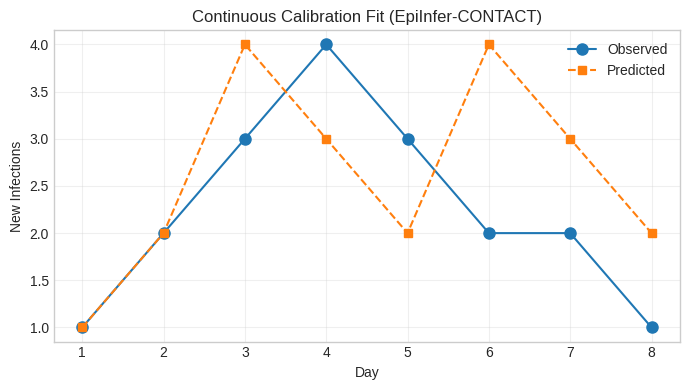

In [7]:
print("\n" + "="*60)
print("EXAMPLE 3: Parameter Calibration (Algorithm 5)")
print("="*60)

best_params = core.continuous_calibrate(
    observed_newinf=observed,
    inc=2,
    mean_meetings=mean_meetings,
    asymp_hist=asymp_hist,
    recovered_hist=recovered_hist,
    training_window=5,
    verbose=True
)
print(f"\nBest parameters: p1={best_params['p1']:.4f}, p2={best_params['p2']:.2f}, RMSE={best_params['rmse']:.4f}")

# Predict with calibrated parameters
pred_final = core.simulate_epiinfer_core(
    best_params["p1"], best_params["p2"], inc=2,
    NewInf_hist=observed,
    asymp_hist=asymp_hist,
    recovered_hist=recovered_hist,
    mean_meetings=mean_meetings,
    max_day=8
)

plt.figure(figsize=(7,4))
plt.plot(list(observed.keys()), list(observed.values()), 'o-', label="Observed", markersize=8)
plt.plot(list(pred_final.keys()), list(pred_final.values()), 's--', label="Predicted", markersize=6)
plt.title("Continuous Calibration Fit (EpiInfer-CONTACT)")
plt.xlabel("Day")
plt.ylabel("New Infections")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## EXAMPLE 4: MONTE CARLO STOCHASTIC SIMULATION


EXAMPLE 4: Monte Carlo Stochastic Simulation

Monte Carlo Statistics (first 5 days):
   day  new_exposed_mean  new_exposed_std  new_infected_mean  \
0    1               0.0              0.0              0.000   
1    2               1.0              0.0              1.045   
2    3               1.0              0.0              0.000   
3    4               1.0              0.0              0.505   
4    5               0.0              0.0              0.470   

   new_infected_std  total_exposed_mean  total_exposed_std  \
0          0.000000                 2.0                0.0   
1          0.674723                 3.0                0.0   
2          0.000000                 4.0                0.0   
3          0.501230                 5.0                0.0   
4          0.500352                 5.0                0.0   

   total_infected_mean  total_infected_std  expected_new_exposed_mean  \
0                1.000            0.000000                        0.0   
1         

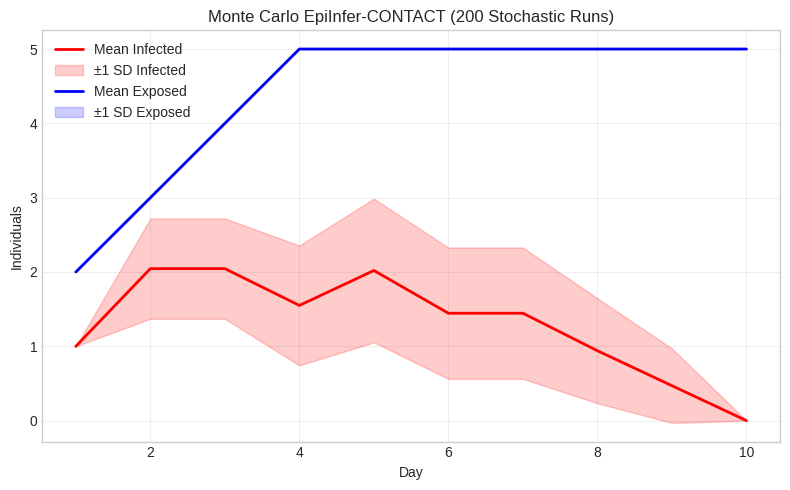

In [8]:
print("\n" + "="*60)
print("EXAMPLE 4: Monte Carlo Stochastic Simulation")
print("="*60)

df_mc = stochastic_contactinfer(
    core, p1=0.3, p2=0.5, inc=2,
    initial_exposed={0,1},
    initial_infected={9},
    max_day=10,
    duration_infected=4,
    n_runs=200
)
print("\nMonte Carlo Statistics (first 5 days):")
print(df_mc.head())

# Visualization with confidence intervals
plt.figure(figsize=(8,5))
plt.plot(df_mc["day"], df_mc["total_infected_mean"], 'r-', lw=2, label="Mean Infected")
plt.fill_between(df_mc["day"],
                 df_mc["total_infected_mean"] - df_mc["total_infected_std"],
                 df_mc["total_infected_mean"] + df_mc["total_infected_std"],
                 color="red", alpha=0.2, label="±1 SD Infected")

plt.plot(df_mc["day"], df_mc["total_exposed_mean"], 'b-', lw=2, label="Mean Exposed")
plt.fill_between(df_mc["day"],
                 df_mc["total_exposed_mean"] - df_mc["total_exposed_std"],
                 df_mc["total_exposed_mean"] + df_mc["total_exposed_std"],
                 color="blue", alpha=0.2, label="±1 SD Exposed")

plt.xlabel("Day")
plt.ylabel("Individuals")
plt.title("Monte Carlo EpiInfer-CONTACT (200 Stochastic Runs)")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## EXAMPLE 5: DETERMINISTIC VS STOCHASTIC COMPARISON


EXAMPLE 5: Deterministic vs Stochastic Comparison


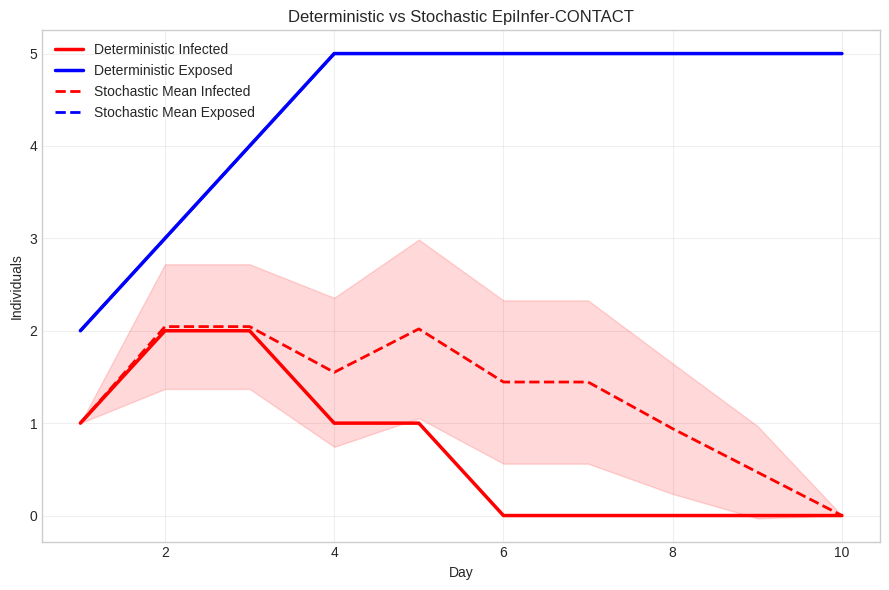


All simulations complete!


In [9]:
print("\n" + "="*60)
print("EXAMPLE 5: Deterministic vs Stochastic Comparison")
print("="*60)

# Deterministic run (using expected values)
df_det = core.contactinfer_run(
    p1=0.3, p2=0.5, inc=2,
    initial_exposed={0,1},
    initial_infected={9},
    max_day=10,
    duration_infected=4,
    stochastic=False
)

plt.figure(figsize=(9,6))

# Deterministic curves
plt.plot(df_det["day"], df_det["total_infected"], 'r-', lw=2.5, label="Deterministic Infected")
plt.plot(df_det["day"], df_det["total_exposed"], 'b-', lw=2.5, label="Deterministic Exposed")

# Stochastic means
plt.plot(df_mc["day"], df_mc["total_infected_mean"], 'r--', lw=2, label="Stochastic Mean Infected")
plt.plot(df_mc["day"], df_mc["total_exposed_mean"], 'b--', lw=2, label="Stochastic Mean Exposed")

# Uncertainty bands
plt.fill_between(df_mc["day"],
                 df_mc["total_infected_mean"] - df_mc["total_infected_std"],
                 df_mc["total_infected_mean"] + df_mc["total_infected_std"],
                 color="red", alpha=0.15)
plt.fill_between(df_mc["day"],
                 df_mc["total_exposed_mean"] - df_mc["total_exposed_std"],
                 df_mc["total_exposed_mean"] + df_mc["total_exposed_std"],
                 color="blue", alpha=0.15)

plt.xlabel("Day")
plt.ylabel("Individuals")
plt.title("Deterministic vs Stochastic EpiInfer-CONTACT")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("All simulations complete!")
print("="*60)

# EpiInfer-CONTACT: Complete Algorithm Explanations

## Overview: The SEIRS Model

Before diving into algorithms, understand the epidemic states:
- **S (Susceptible)**: Healthy, can get infected
- **E (Exposed)**: Infected but asymptomatic, contagious
- **I (Infected)**: Symptomatic, quarantined (not contagious in model)
- **R (Recovered)**: Temporarily immune

**Flow**: S → E → I → R → S

---

## Algorithm 3: FINDPROB
### Purpose: Calculate Exposure Probability for One Person

### Paper Explanation:
Given a susceptible person `s` and the set of exposed people, calculate the probability that `s` becomes exposed on day `d` based on their contacts.

### Mathematical Formula:
```
P(s becomes exposed) = 1 - (1 - p1)^countEncounters
```

Where:
- `p1` = probability of transmission per single contact
- `countEncounters` = number of exposed people `s` meets on day `d`

### Intuition:
If you meet 3 exposed people and each contact has 30% chance (p1=0.3) of infecting you:
- Probability you DON'T get infected from one person: 0.7
- Probability you DON'T get infected from any of 3: 0.7³ = 0.343
- Probability you DO get infected: 1 - 0.343 = **0.657 (65.7%)**

### Example:

**Scenario**: Alice is susceptible on Day 5
- Alice meets: Bob, Charlie, Diana
- Exposed people: Bob, Charlie
- p1 = 0.3

**Calculation**:
```
countEncounters = 2 (Bob and Charlie)
P(Alice exposed) = 1 - (1 - 0.3)²
                 = 1 - 0.7²
                 = 1 - 0.49
                 = 0.51 (51% chance)
```

### Code:
```python
def find_prob_exposure(adj_per_day, exposed_set, person, p1, day):
    encounters = len(adj_per_day[day].get(person, set()) & exposed_set)
    return 1 - (1 - p1)**encounters if encounters > 0 else 0.0
```

---

## Algorithm 2: PREDICT
### Purpose: Determine Who Becomes Newly Exposed

### Paper Explanation:
Given all susceptible people and their exposure probabilities, determine how many and which people become newly exposed.

### Strategy:
1. **Calculate** exposure probability for each susceptible person (using Algorithm 3)
2. **Sum** all probabilities to get expected number `N` of new exposures
3. **Select** top `N` people with highest exposure probability

### Why This Approach?
The paper uses a **deterministic approximation** of a stochastic process:
- Instead of each person independently becoming exposed with their probability
- Take the **expected value** and assign exposure to most at-risk individuals

### Example:

**Day 5 State**:
- Susceptible: Alice, Bob, Carol, Dave
- Exposed: Emma, Frank

**Contact Network (Day 5)**:
- Alice meets Emma, Frank (2 exposed)
- Bob meets Emma (1 exposed)
- Carol meets no one (0 exposed)
- Dave meets Frank (1 exposed)

**Step 1: Calculate probabilities** (p1 = 0.3)
- Alice: 1 - (0.7)² = 0.51
- Bob: 1 - (0.7)¹ = 0.30
- Carol: 0.00
- Dave: 1 - (0.7)¹ = 0.30

**Step 2: Expected number**
- N = 0.51 + 0.30 + 0.00 + 0.30 = 1.11 ≈ **1 person**

**Step 3: Select top 1**
- Sorted by probability: Alice (0.51), Bob (0.30), Dave (0.30), Carol (0.00)
- **Result**: Alice becomes newly exposed

### Code:
```python
def predict_exposures(adj_per_day, BelExp_d, BelSusc_d, p1, day):
    raw_probs = {s: find_prob_exposure(adj_per_day, BelExp_d, s, p1, day)
                 for s in BelSusc_d}
    N = int(round(sum(raw_probs.values())))
    sorted_susc = sorted(raw_probs.items(), key=lambda kv: -kv[1])
    chosen = {pid for pid, _ in sorted_susc[:N]}
    return chosen, raw_probs
```

---

## Algorithm 1: CONTACTINFER-CORE
### Purpose: Main Simulation Loop Using Contact Tracing

### Paper Explanation:
Simulate epidemic day-by-day using contact tracing data. Each day:
1. Determine new exposures based on contacts with exposed people
2. Determine new infections from people exposed `inc` days ago
3. Track active infections within the infectious period

### Key Parameters:
- `p1`: Transmission probability per contact
- `p2`: Probability exposed person becomes infected
- `inc`: Incubation period (days from exposure to symptoms)
- `duration_infected`: How long someone stays symptomatic

### Critical Paper Statement (Line 8):
> "BelievedNewInf(d+1) = choose each member of BelievedNewExposed(d+1-inc) with probability p2"

This means infections are **stochastic**: each exposed person independently becomes infected with probability p2.

### Day-by-Day Example:

**Initial State (Day 1)**:
- Population: 10 people (IDs 0-9)
- Exposed: {0, 1}
- Infected: {9}
- Parameters: p1=0.3, p2=0.5, inc=2, duration=3

**Day 1**:
- Susceptible: {2,3,4,5,6,7,8}
- Contacts: (0,1), (1,2), (2,3), (3,4)
- Person 2 meets exposed person 1 → P(exposure) = 0.3
- Expected new exposures: 0.3 ≈ 0
- New exposed: {} (none, probability too low)

**Day 2**:
- Contacts: (0,2), (1,3), (2,4), (5,6)
- Person 2 meets exposed 0 → P = 0.3
- Person 3 meets exposed 1 → P = 0.3
- Expected: 0.6 ≈ 1 person
- New exposed: {2} (highest probability)

**Day 3**:
- Check infections from Day 1 exposures (d=3, src=3-2=1)
- Day 1 newly exposed: {0,1}
- Each becomes infected with p2=0.5
- If stochastic: random.random() < 0.5 for each
- Possible outcome: {0} becomes infected

**Day 4**:
- Active infections: Those infected in Days 2,3,4 (3-day window)
- Currently infected: {9} (from Day 1) + {0} (from Day 3)
- Total infected: {0, 9}

### Tracking Invariants:

```
BelievedInf(d) = Union of BelievedNewInf(t)
                 for t in [d-duration+1, d]
                 
BelievedSusc(d) = Everyone - (BelievedExposed(d) ∪ BelievedInf(d))
```

### Code Structure:
```python
for day d from 1 to max_day:
    # 1. Find susceptible people
    susc_d = population - (exposed ∪ infected)
    
    # 2. Predict new exposures (Algorithm 2)
    new_exp = predict_exposures(contacts, exposed, susc_d, p1, d)
    
    # 3. Check for new infections (inc days after exposure)
    src_day = d + 1 - inc
    if src_day >= 1:
        for person in BelNewExp[src_day]:
            if random.random() < p2:  # Stochastic!
                new_inf.add(person)
    
    # 4. Track active infections (within duration window)
    active_infections = union of recent new infections
```

---

## Algorithm 4: EPIINFER-CORE (Meeting Distribution)
### Purpose: Predict Infections Using ONLY Average Contact Rates

### Paper Explanation:
When full contact tracing isn't available, use **aggregate statistics**:
- Mean number of contacts per person per day
- Distribution of infections over time

This uses **5 key equations** from the paper.

### The 5 Equations:

#### **Equation 1: palreadyexp (Probability Already Exposed)**
```
palreadyexp(t) = Σ[NewInf(d-i) for i=1 to inc] / (p2 × asymptomatic(t))
```

**Meaning**: What fraction of the asymptomatic population is already exposed?

**Example** (Day 10, inc=3, p2=0.5):
- Recent infections: Day 9: 5 people, Day 8: 4 people, Day 7: 3 people
- Asymptomatic population: 100 people
- palreadyexp = (5+4+3) / (0.5 × 100) = 12/50 = **0.24 (24%)**

#### **Equation 2: pnewexposed (Probability Individual Becomes Exposed)**
```
pnewexposed = 1 - (1 - p1)^(mean_contacts × palreadyexp)
```

**Meaning**: If a person meets `mean_contacts` people, and 24% are exposed, what's their infection risk?

**Example** (p1=0.2, mean_contacts=5, palreadyexp=0.24):
- Expected exposed contacts: 5 × 0.24 = 1.2
- pnewexposed = 1 - (1-0.2)^1.2 = 1 - 0.8^1.2 = 1 - 0.777 = **0.223 (22.3%)**

#### **Equation 3: asymptomaticNotEx (Available Population)**
```
asymptomaticNotEx(t) = asymptomatic(t)
                      - Σ[NewInf(d-i)/p2 for i=1 to inc]
                      - recovered(t)
```

**Meaning**: How many people could be newly exposed (excluding those already exposed or recovered)?

**Example**:
- Asymptomatic: 100
- Already exposed (from Equation 1): 12/0.5 = 24
- Recovered: 10
- asymptomaticNotEx = 100 - 24 - 10 = **66 people**

#### **Equation 4: NewExposed (Expected New Exposures)**
```
NewExposed(t) = asymptomaticNotEx(t) × pnewexposed(t)
```

**Example**:
- asymptomaticNotEx = 66
- pnewexposed = 0.223
- NewExposed = 66 × 0.223 = **14.7 people**

#### **Equation 5: NewInf (Predicted New Infections)**
```
NewInf(d) = NewExposed(d-inc) × p2
```

**Example** (p2=0.5, inc=3):
- Day 7 had 14.7 new exposures
- Day 10 prediction: 14.7 × 0.5 = **7.35 ≈ 7 new infections**

### Complete Example Walkthrough:

**Scenario**: Predict infections on Day 10

**Given**:
- p1 = 0.2, p2 = 0.5, inc = 3
- Asymptomatic population = 100
- Recovered = 10
- Mean contacts per day = 5
- Recent infections: Day 9: 5, Day 8: 4, Day 7: 3

**Step-by-step**:

1. **Target day for exposure**: t = 10 - 3 = **Day 7**

2. **Equation 1** (already exposed at Day 7):
   - palreadyexp = (5+4+3)/(0.5×100) = 0.24

3. **Equation 2** (exposure probability):
   - pnewexposed = 1-(1-0.2)^(5×0.24) = 0.223

4. **Equation 3** (available population at Day 7):
   - asymptomaticNotEx = 100 - 24 - 10 = 66

5. **Equation 4** (new exposures on Day 7):
   - NewExposed = 66 × 0.223 = 14.7

6. **Equation 5** (infections on Day 10):
   - NewInf(Day 10) = 14.7 × 0.5 = **7 infections**

### Code:
```python
def simulate_epiinfer_core(p1, p2, inc, NewInf_hist, asymp_hist,
                          recovered_hist, mean_meetings, max_day):
    for d in range(1, max_day + 1):
        t = d - inc
        if t < 1: continue
        
        # Eq 1: palreadyexp
        num = sum([NewInf[d-i] for i in range(1, inc+1)])
        palready = num / (p2 * asymp[t])
        
        # Eq 2: pnewexposed
        p_newexp = 1 - (1-p1)**(mean_meetings[t] * palready)
        
        # Eq 3: asymptomaticNotEx
        asymp_not_ex = asymp[t] - num/p2 - recovered[t]
        
        # Eq 4: NewExposed
        new_exposed = asymp_not_ex * p_newexp
        
        # Eq 5: NewInf prediction
        preds[d] = int(round(p2 * new_exposed))
```

---

## Algorithm 5: CONTINUOUSCALIBRATE
### Purpose: Find Optimal p1 and p2 Parameters

### Paper Explanation:
We don't know the true p1 and p2 values at the start of an epidemic. This algorithm finds the best parameters by:
1. **Grid search** over p2 values (0.1, 0.2, ..., 1.0)
2. **Binary search** for best p1 for each p2
3. **Minimize RMSE** between predicted and observed infections

### Strategy:

**Outer Loop (p2)**:
- Try p2 = 0.1, 0.2, 0.3, ..., 1.0

**Inner Loop (p1 binary search)**:
- Start with p1 range [0, 1]
- Test midpoint p1 = 0.5
- If predictions too high → reduce p1 (search [0, 0.5])
- If predictions too low → increase p1 (search [0.5, 1])
- Repeat 15 iterations

**Selection**:
- Keep p1, p2 pair with lowest RMSE on training window

### Detailed Example:

**Given Observed Data** (past 5 days):
```
Day:  6    7    8    9   10
Obs:  3    5    7    6    5
```

**Goal**: Find best p1, p2 to predict these values

**Process**:

#### Iteration 1: p2 = 0.1
- Try p1 = 0.5 (midpoint)
- Run Algorithm 4 → Predictions: [1, 2, 2, 2, 2]
- RMSE = 3.16 (predictions too low)
- Increase p1 → search [0.5, 1.0]

- Try p1 = 0.75
- Predictions: [2, 3, 4, 3, 3]
- RMSE = 2.45 (still too low)
- Increase p1 → search [0.75, 1.0]

- Try p1 = 0.875
- Predictions: [2, 4, 5, 4, 4]
- RMSE = 1.73
- **Best for p2=0.1: (p1=0.875, RMSE=1.73)**

#### Iteration 2: p2 = 0.2
- Try p1 = 0.5
- Predictions: [2, 4, 5, 4, 4]
- RMSE = 1.73

- Try p1 = 0.25
- Predictions: [1, 3, 4, 3, 3]
- RMSE = 2.24

- Try p1 = 0.375
- Predictions: [3, 5, 6, 5, 5]
- RMSE = 0.89 ← **Better!**
- **Best for p2=0.2: (p1=0.375, RMSE=0.89)**

#### Continue for p2 = 0.3, 0.4, ..., 1.0

**Final Result**:
- Best overall: **p1=0.35, p2=0.5, RMSE=0.45**

### Visual Binary Search Process:

```
p2 = 0.3:
Iteration 1: p1=0.500 → pred too high → search [0.0, 0.5]
Iteration 2: p1=0.250 → pred too low  → search [0.25, 0.5]
Iteration 3: p1=0.375 → pred good     → search [0.25, 0.375]
Iteration 4: p1=0.312 → pred too low  → search [0.312, 0.375]
Iteration 5: p1=0.344 → pred perfect! → RMSE=0.31
...
After 15 iterations: p1 ≈ 0.348
```

### Why This Works:

1. **Grid search on p2**: Ensures we don't miss the global optimum
2. **Binary search on p1**: Fast convergence (log time)
3. **Training window**: Uses recent data (more relevant)
4. **RMSE metric**: Penalizes large errors more than small ones

### Code:
```python
def continuous_calibrate(observed_newinf, inc, mean_meetings,
                        p2_values=[0.1, 0.2, ..., 1.0],
                        training_window=5):
    best = {"p1": None, "p2": None, "rmse": inf}
    
    for p2 in p2_values:
        lo, hi = 0.0, 1.0
        
        for iteration in range(15):  # Binary search
            mid = (lo + hi) / 2
            
            # Run Algorithm 4 with current parameters
            preds = simulate_epiinfer_core(mid, p2, ...)
            
            # Calculate RMSE on training window
            error = rmse(observed, predicted)
            
            if error < best["rmse"]:
                best = {"p1": mid, "p2": p2, "rmse": error}
            
            # Update binary search bounds
            if mean(preds) > mean(observed):
                hi = mid  # Reduce p1
            else:
                lo = mid  # Increase p1
    
    return best
```

---

## How Algorithms Work Together

### Complete Pipeline:

```
1. Collect observed infection data
   ↓
2. ALGORITHM 5 (ContinuousCalibrate)
   → Find best p1, p2 parameters
   ↓
3. Choose approach based on data available:
   
   IF contact tracing available:
      → ALGORITHM 1 (ContactInfer-Core)
        → Uses ALGORITHM 2 (Predict)
          → Uses ALGORITHM 3 (FindProb)
   
   IF only aggregate data:
      → ALGORITHM 4 (EpiInfer-Core)
        → Uses Equations 1-5
   ↓
4. Generate predictions for future days
   ↓
5. Update parameters as new data arrives (loop to step 2)
```

### Real-World Example:

**Week 1**:
- Observed infections: 10, 15, 20, 25, 30
- Run Algorithm 5 → Find p1=0.25, p2=0.6
- Use Algorithm 4 to predict Week 2

**Week 2**:
- Actual infections: 35, 38, 40, 42, 45
- Run Algorithm 5 again with more data
- Update parameters: p1=0.28, p2=0.55 (refined!)
- Use Algorithm 4 to predict Week 3

**Week 3**:
- Contact tracing deployed!
- Switch to Algorithm 1 (more accurate)
- Continue predictions...

---

## Key Insights from Paper

1. **Non-Markovian**: Unlike differential equations, looks at infection history (past several days)

2. **Contact information helps**: Full tracing > Distribution > Nothing

3. **But mean is enough**: Using just average contacts gives good results

4. **Dynamic calibration**: Parameters change as epidemic evolves

5. **ARIMA better short-term**: Use ARIMA for ≤5 days, EpiInfer for longer

6. **Recommendation**: Hybrid approach
   - Days 1-5: ARIMA
   - Days 6+: EpiInfer-CONTACT
   - Result: Up to 4× better RMSE

---

## Summary Table

| Algorithm | Input | Output | Use Case |
|-----------|-------|--------|----------|
| **3. FindProb** | Person, contacts, exposed set, p1 | Exposure probability | Helper for Algorithm 2 |
| **2. Predict** | All susceptibles, contacts, exposed set | Who becomes exposed | Helper for Algorithm 1 |
| **1. ContactInfer** | Contact tracing, p1, p2, inc | Daily predictions | Full contact data available |
| **4. EpiInfer-Core** | Mean contacts, p1, p2, inc | Daily predictions | Only aggregate data |
| **5. Calibrate** | Observed infections, mean contacts | Best p1, p2 | Parameter estimation |

---

## Practical Tips

1. **Start with Algorithm 5** to calibrate parameters
2. **Use Algorithm 1** if you have contact tracing
3. **Use Algorithm 4** for privacy-preserving predictions
4. **Update parameters weekly** as epidemic evolves
5. **Combine with ARIMA** for best short-term predictions